In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import jaccard_similarity_score

In [6]:
desc = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/2_1_gold_descriptor_combined.tsv", index_col = [0,1])

In [ ]:
drug_mat = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/4_2_gold_se_by_indep_matrix.tsv", index_col=0)

In [ ]:
drug_mat.head(1)

In [5]:
#2017.3.27 drug-drug_similarity 구하기
gold_drug_id = drug_mat.columns.values
df_dr_sim = pd.DataFrame()
mat_dr_sim = pd.DataFrame(columns = gold_drug_id, index = gold_drug_id)
cnt = 0
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for i in gold_drug_id:
    desc1 = drug_mat[i]
    for j in gold_drug_id:
        desc2 = drug_mat[j]
        
        sim = jaccard_similarity_score(desc1, desc2)
        
        #dataframe형
        temp_df = pd.DataFrame(data= [[i, j , sim]], columns=['Drug_id1', 'Drug_id2', 'Similarity'])
        df_dr_sim = df_dr_sim.append(temp_df)
        # matrix형
        mat_dr_sim[i].ix[j] = sim
    cnt = cnt + 1
    if cnt % 100 == 0:
        print 'cnt == {} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

start : 2017-03-27 22:11:14
cnt == 100 : 2017-03-27 22:12:33
cnt == 200 : 2017-03-27 22:14:14
cnt == 300 : 2017-03-27 22:16:18
cnt == 400 : 2017-03-27 22:18:43
end : 2017-03-27 22:19:56


In [6]:
df_dr_sim.to_csv("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/5_gold_drug_drug_sim_predict.tsv", sep='\t', index=False)
df_dr_sim.to_csv("/DAS_Storage1/aschoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/5_gold_drug_drug_sim_predict.tsv", sep='\t', index=False)
mat_dr_sim.to_csv("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/5_2_gold_drug_drug_sim_mat_predict.tsv", sep='\t')
mat_dr_sim.to_csv("/DAS_Storage1/aschoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/5_2_gold_drug_drug_sim_mat_predict.tsv", sep='\t')

In [15]:
#2017.3.15. drug-disease similarity #normalize 함. (4.18. 추가. 사실은 안한거였다... )
df_dr_sim = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/5_new_drug/PREDICT_data/5_gold_drug_drug_sim_predict.tsv")
df_di_sim = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/6_new_disease/10_gold_disease_disease_sim.tsv")
df_asso = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/2_gold_asso.tsv")

In [3]:
print df_asso.head(1)
df_asso = df_asso.rename(columns={'DrugBank_ID' : 'drug_id', 'OMIM_ID' : 'disease_id'})
df_asso.head(1)

  DrugBank_ID  OMIM_ID
0     DB00659   103780


,drug_id,disease_id
0,DB00659,103780


In [4]:
# 4.18. normalize 버전
gold_drug_id = df_asso['drug_id'].drop_duplicates().tolist()
gold_disease_id = df_asso['disease_id'].drop_duplicates().tolist()
di_dr_mat = pd.DataFrame(columns = gold_drug_id, index= gold_disease_id) #di에 대한 dr의 distance보기
cnt = 0 
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for i in gold_drug_id:
    other_drugs_sim = df_dr_sim[(df_dr_sim.Drug_id1 == i) & (df_dr_sim.Drug_id2 != i)] # 검사할 drug를 제외한 다른 drug들
    for j in gold_disease_id:
        target_disease = df_asso[(df_asso.disease_id ==int(j))] # 검사할 disease
        flags = other_drugs_sim['Drug_id2'].isin(target_disease['drug_id']) # 검사할 disease와 다른 drug들의 association여부
        sum_selected_drug = other_drugs_sim[flags]['Similarity'].sum() # association이 있는 것들의 합
        sum_all_drug = other_drugs_sim['Similarity'].sum() # similarity의 전체 합
        norm = sum_selected_drug / sum_all_drug #normalize한 값
        #di_dr_mat[i].ix[j] = sum_selected_drug
        di_dr_mat[i].ix[j] = norm
    cnt = cnt + 1
    if cnt % 100 == 0:
        print 'cnt == {} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

start : 2017-04-19 00:55:42
cnt == 100 : 2017-04-19 00:56:26
cnt == 200 : 2017-04-19 00:57:08
cnt == 300 : 2017-04-19 00:57:49
cnt == 400 : 2017-04-19 00:58:30
end : 2017-04-19 00:58:49


In [5]:
#2017.3.15. disease-drug similarity #normalize 한 버전(아님...<-4.18. 추가)
dr_di_mat = pd.DataFrame(columns = gold_drug_id, index= gold_disease_id) #dr에 대한 di의 distance보기
cnt = 0 
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for i in gold_disease_id:
    other_diseases_sim = df_di_sim[(df_di_sim.Disease_id1 == int(i)) & (df_di_sim.Disease_id2 != int(i))] # 검사할 disease를 제외한 다른 disease들
    for j in gold_drug_id:
        target_drug = df_asso[(df_asso.drug_id ==j)] # 검사할 drug
        flags = other_diseases_sim['Disease_id2'].isin(target_drug['disease_id']) # 검사할 drug와 다른 disease들의 association여부
        sum_selected_disease = other_diseases_sim[flags]['Similarity'].sum() # association이 있는 것들의 합
        sum_all_disease = other_diseases_sim['Similarity'].sum() # similarity의 전체 합
        norm = sum_selected_disease / sum_all_disease #normalize한 값
        #dr_di_mat[j].ix[i] = sum_selected_disease
        dr_di_mat[j].ix[i] = norm
    cnt = cnt + 1
    if cnt % 100 == 0:
        print 'cnt == {} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

start : 2017-04-19 00:58:49
cnt == 100 : 2017-04-19 01:00:05
cnt == 200 : 2017-04-19 01:01:32
end : 2017-04-19 01:02:05


In [6]:
bef_distance = -(di_dr_mat+dr_di_mat)
distance_mat = pd.DataFrame(columns = bef_distance.columns.values, index = bef_distance.index.values)
cnt = 0 
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for i in bef_distance.columns.values:
    for j in bef_distance.index.values:
        a = bef_distance[i].ix[j]
        distance = np.exp(a)
        distance_mat[i].ix[j] = distance
    cnt = cnt + 1
    if cnt % 100 == 0:
        print 'cnt == {} : '.format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

start : 2017-04-19 01:02:05
cnt == 100 : 2017-04-19 01:02:14
cnt == 200 : 2017-04-19 01:02:23
cnt == 300 : 2017-04-19 01:02:32
cnt == 400 : 2017-04-19 01:02:42
end : 2017-04-19 01:02:47


In [7]:
# 2017.4.18. normalize 한거.
print di_dr_mat.min().min() #drisease-drug sim의 최소값
print di_dr_mat.max().max() #disease-drug sim의 최대값
print dr_di_mat.min().min() #drug-disease sim의 최소값
print dr_di_mat.max().max() #drug-disease sim의 최소값
print (di_dr_mat + dr_di_mat).min().min() #위 두 결과를 더한 matrix의 최소값 (sim의 합의 최소값)
print (di_dr_mat + dr_di_mat).max().max() #위 두 결과를 더한 matrix의 최대값 (sim의 합의 최대값)
print bef_distance.min().min() #  - (sim의 합의 최대값)--> 최소값 --> 이 값을 exp에 넣으면 거리는 최소가 됨.
print bef_distance.max().max() #  - (sim의 합의 최소값)--> 최대값 --> 이 값을 exp에 넣으면 거리는 최대가 됨.
print np.exp(bef_distance.min().min()) #거리의 최소값 = 가까운 거리
print np.exp(bef_distance.max().max()) # 거리의 최대값 = 먼 거리

0.0
0.17366463154
0.0
0.0812943794645
0.0
0.252886065564
-0.252886065564
-0.0
0.776556353293
1.0


In [7]:
# normalize 아닌 애들..
print di_dr_mat.min().min() #drisease-drug sim의 최소값
print di_dr_mat.max().max() #disease-drug sim의 최대값
print dr_di_mat.min().min() #drug-disease sim의 최소값
print dr_di_mat.max().max() #drug-disease sim의 최소값
print (di_dr_mat + dr_di_mat).min().min() #위 두 결과를 더한 matrix의 최소값 (sim의 합의 최소값)
print (di_dr_mat + dr_di_mat).max().max() #위 두 결과를 더한 matrix의 최대값 (sim의 합의 최대값)
print bef_distance.min().min() #  - (sim의 합의 최대값)--> 최소값 --> 이 값을 exp에 넣으면 거리는 최소가 됨.
print bef_distance.max().max() #  - (sim의 합의 최소값)--> 최대값 --> 이 값을 exp에 넣으면 거리는 최대가 됨.
print np.exp(bef_distance.min().min()) #거리의 최소값 = 가까운 거리
print np.exp(bef_distance.max().max()) # 거리의 최대값 = 먼 거리

0.0
68.3454446855
0.0
18.7744958819
0.0
81.6126634984
-81.6126634984
0.0
3.59807812731e-36
1.0


In [20]:
# 4.18. normalize 한 애들
distance_mat.to_csv("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/4_2_drug_disease_norm_distance_predict.tsv", sep='\t')
distance_mat.to_csv("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/7_new_association/PREDICT_data/4_2_drug_disease_norm_distance_predict.tsv", sep='\t')

In [11]:
# Similarity histogram (2017.4.18.)
summed_sim = list()
for index, row in (di_dr_mat + dr_di_mat).iterrows():
    for l in row:
        summed_sim.append(l)
print len(summed_sim) # drug (471) * disease(235)

104810


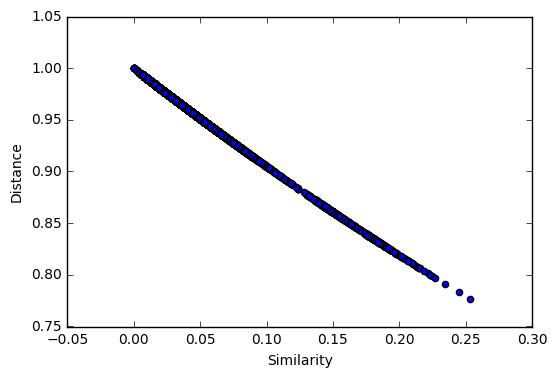

In [14]:
# Similarity 분포를 보려고 (2017.4.18.)
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py
%matplotlib inline
#num_bins = 30
#plt.hist(summed_sim, num_bins)
plt.scatter(summed_sim, val) ## sim이 낮을 수록 거리가 멀다.
plt.xlabel("Similarity")
plt.ylabel("Distance")
#plt.xlim(0,20)
#plt.ylim(0, 0.2)
#plt.ylim(0.10, 0.14)

(0, 0.6)

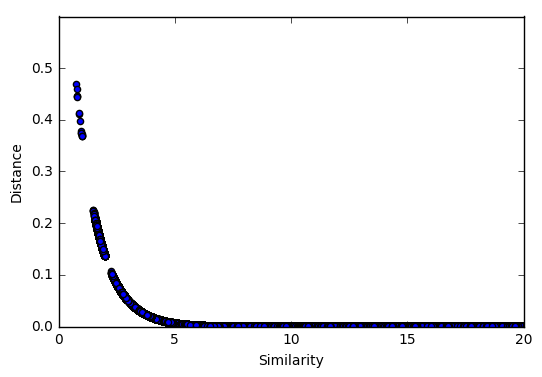

In [26]:
# normalize 안한거의 그래프
plt.scatter(summed_sim, val) ## sim이 낮을 수록 거리가 멀다.
plt.xlabel("Similarity")
plt.ylabel("Distance")
plt.xlim(0,20)
plt.ylim(0, 0.6)
#plt.ylim(0.10, 0.14)

In [ ]:
# TN 찾기 2017.3.15. -> 다 normalize 안한 버전임.

In [13]:
# Distance histogram 그리기 (2017.3.27. 추가)
val = list()
for index, row in distance_mat.iterrows():
    for k in row:
        val.append(k)
print len(val) # drug (446) * disease(235)

104810


In [ ]:
# 거리가 0.12 이상인 애들을 negative association으로 고려한다.

In [42]:
# 전체 distance matrix에서 거리가 0.1보다 큰 애들을 찾는다. (거리가 먼 애들)
# 전체 distance matrix에서 거리가 0.05보다 큰 애들을 찾는다. (거리가 먼 애들)
li_tn = list()
for index, row in distance_mat.iterrows():
    filtered = row[row> 0.05]
    if not filtered.empty:
        li_tn.append([index, filtered.index.tolist()]) 
df_tn = pd.DataFrame()
for i in li_tn:
    for j in i[1]:
        temp_df = pd.DataFrame(data = [[i[0], j]], columns = ['disease_id', 'drug_id'])
        df_tn = df_tn.append(temp_df)

In [43]:
print len(df_tn)
print len(df_tn.drop_duplicates())
print len(df_tn.drop_duplicates('disease_id'))
print len(df_tn.drop_duplicates('drug_id'))
df_tn.head(1)

20286
20286
122
260


,disease_id,drug_id
0,147480,DB00659


In [44]:
li_row

['DB00909', 190300]

In [45]:
# 구한 TN이 positive associaion과 겹치는게 있는지 체크
duplicated = pd.DataFrame()
for index, row in df_asso.iterrows():
    li_row = row.tolist()
    temp = df_tn[(df_tn.disease_id == li_row[1]) & (df_tn.drug_id == li_row[0])]
    if temp.empty:
        continue
    else:
        duplicated = duplicated.append(temp)
print len(duplicated)

80


In [46]:
# duplicated 를 제외한 나머지 dataframe 
duplicated['key'] = 0
tt = pd.merge(left = df_tn, right = duplicated, how='left')
df_tn2 = tt[tt.key != 0][['disease_id', 'drug_id']]

In [47]:
print len(df_tn2)
print len(df_tn2.drop_duplicates())
print len(df_tn2.drop_duplicates('disease_id'))
print len(df_tn2.drop_duplicates('drug_id'))

20206
20206
117
243


In [48]:
df_tn2.to_csv("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/7_new_association/PREDICT_data/5_1_2_true_negative_whole_005_predict.tsv", sep='\t', index=False)
df_tn2.to_csv("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/5_1_2_true_negative_whole_005_predict.tsv", sep='\t', index=False)

In [49]:
# negative descriptor 만들기 -whole (2017.3.27.)
df_tn_desc = pd.DataFrame()
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for index, row in df_tn2.iterrows():
    temp_df = desc[(desc.drug_id == row['drug_id']) & (desc.disease_id == int(row['disease_id']))]
    if temp_df.empty:
        continue
    else:
        df_tn_desc = df_tn_desc.append(temp_df)
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

start : 2017-03-27 23:19:37
end : 2017-03-28 00:09:16


In [50]:
desc_pos = desc[desc.association ==1]
frames = [desc_pos, df_tn_desc]
whole_desc = pd.concat(frames)

In [51]:
print len(df_tn_desc)
print len(desc_pos)
print len(whole_desc)
print len(whole_desc.drop_duplicates())

19975
1362
21337
21337


In [52]:
#whole_desc.to_csv("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/PREDICT_data/7_2_1_tn_whole_descriptor_removed.tsv", sep='\t', index=False)
whole_desc.to_csv("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/3_1_tn_whole_descriptor_005_predict.tsv", sep='\t', index=False)

In [ ]:
# TN 찾기 (local 고려, pos 정보 없앰.) 2017.3.28. ->4.18. normalize 버전으로 다시 수정

In [23]:
#asso_mat = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/2_3_gold_asso_matrix.tsv", index_col=0)

In [ ]:
distance_mat = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/4_2_drug_disease_norm_distance_predict.tsv", sep='\t', index_col=0)

In [24]:
'''mat = distance_mat - asso_mat
print len(mat)
mat.head(1)'''

'mat = distance_mat - asso_mat\nprint len(mat)\nmat.head(1)'

In [25]:
# di당 거리가 먼 dr을 일정비율로 뽑는다.
li_tn_di = list()
for index, row in distance_mat.iterrows():
    #idx = int(len(row)*0.1)
    idx = 29
    filtered = row.sort_values(ascending=False)[:idx]
    li_tn_di.append([index, filtered.index.tolist()])

df_tn_di = pd.DataFrame()
for i in li_tn_di:
    for j in i[1]:
        temp_df = pd.DataFrame(data=[[i[0], j]], columns = ['disease_id', 'drug_id'])
        df_tn_di= df_tn_di.append(temp_df)

In [26]:
# dr당 거리가 먼 di을 일정비율로 뽑는다.
li_tn_dr = list()
for column in distance_mat:
    #idx = int(len(distance_mat2[column])*0.1)
    idx = 15
    filtered = distance_mat[column].sort_values(ascending=False)[:idx]
    li_tn_dr.append([column, filtered.index.tolist()])

df_tn_dr = pd.DataFrame()
for i in li_tn_dr:
    for j in i[1]:
        temp_df = pd.DataFrame(data=[[j, i[0]]], columns = ['disease_id', 'drug_id'])
        df_tn_dr= df_tn_dr.append(temp_df)

In [30]:
concatenated = pd.concat([df_tn_di, df_tn_dr]).drop_duplicates()
print len(concatenated)
concatenated.index = range(len(concatenated))
concatenated.head(2)

12927


,disease_id,drug_id
0,103780,DB00659
1,103780,DB00704


In [37]:
# 구한 TN이 positive associaion과 겹치는게 있는지 체크
duplicated = pd.DataFrame()
for index, row in df_asso.iterrows():
    li_row = row.tolist()
    temp = concatenated[(concatenated.disease_id == li_row[1]) & (concatenated.drug_id == li_row[0])]
    if temp.empty:
        continue
    else:
        duplicated = duplicated.append(temp)
print len(duplicated)
dup_free = concatenated.drop(concatenated.index[duplicated.index.tolist()])
print len(dup_free)

494
12433


In [38]:
# 구한 TN이 indep과 겹치는게 있는지 체크
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/2_2_indep_descriptor.tsv")

In [44]:
duplicated = pd.DataFrame()
dup_free.index = range(len(dup_free))
for index, row in indep[['drug_id', 'disease_id']].iterrows():
    li_row = row.tolist()
    temp = dup_free[(dup_free.disease_id == li_row[1]) & (dup_free.drug_id == li_row[0])]
    if temp.empty:
        continue
    else:
        duplicated = duplicated.append(temp)
print len(duplicated)
dup_free2 = dup_free.drop(dup_free.index[duplicated.index.tolist()])
print len(dup_free2)

127
12306


In [46]:
dup_free2.to_csv("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/5_2_2_tn_local_norm.tsv", sep='\t', index=False)
dup_free2.to_csv("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/7_new_association/PREDICT_data/5_2_2_tn_local_norm.tsv", sep='\t', index=False)

In [3]:
# negative descriptor 만들기 -local -> 4.18 수정.

In [3]:
concatenated = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/PREDICT_data/5_2_2_tn_local_norm.tsv")

In [7]:
print len(concatenated)
print len(concatenated.drop_duplicates())
concatenated.head(1)

12306
12306


,disease_id,drug_id
0,103780,DB01623


In [10]:
tns = [tuple(x) for x in concatenated[['drug_id', 'disease_id']].values]

In [24]:
df_tn_desc = desc.filter(items = tns, axis=0)
print len(df_tn_desc)

12306


In [6]:
# 이전 방법
df_tn_desc = pd.DataFrame()
cnt = 0
print 'start : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for index, row in concatenated.iterrows():
    temp_df = desc[(desc.drug_id == row['drug_id']) & (desc.disease_id == int(row['disease_id']))]
    if temp_df.empty:
        continue
    else:
        df_tn_desc = df_tn_desc.append(temp_df)
    cnt = cnt + 1
    if cnt % 1000 == 0:
        print "cnt : {}  ".format(cnt) + datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print 'end : ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

start : 2017-03-28 19:41:19
cnt : 1000  2017-03-28 19:41:31
cnt : 2000  2017-03-28 19:41:51
cnt : 3000  2017-03-28 19:42:19
cnt : 4000  2017-03-28 19:42:56
cnt : 5000  2017-03-28 19:44:06
cnt : 6000  2017-03-28 19:45:29
cnt : 7000  2017-03-28 19:47:06
cnt : 8000  2017-03-28 19:48:57
cnt : 9000  2017-03-28 19:51:01
cnt : 10000  2017-03-28 19:53:20
cnt : 11000  2017-03-28 19:55:52
cnt : 12000  2017-03-28 19:58:38
end : 2017-03-28 20:01:16


In [25]:
desc_pos = desc[desc.association ==1]
frames = [desc_pos, df_tn_desc]
whole_desc = pd.concat(frames)

In [26]:
print len(desc_pos)
print len(df_tn_desc)
print len(whole_desc)

1362
12306
13668


In [29]:
print len(whole_desc.index.get_level_values(0).drop_duplicates())
print len(whole_desc.index.get_level_values(1).drop_duplicates())

446
235


In [30]:
#whole_desc.to_csv("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/6_2_1_tn_whole_descriptor.tsv", sep='\t', index=False)
whole_desc.to_csv("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/PREDICT_data/6_tn_local_norm_descriptor.tsv", sep='\t')